# Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from PIL import Image
import os
from datetime import datetime
import torch.nn.functional as F

# Data Loading
We want to upload our data in a format that a CNN can understand. In our case our images are 128 by 128 pixels with colors. The shape of each image is $(128, 128, 3)$.

```load_image``` transforms image to a ```numpy``` array of size $(128, 128, 3)$, while ```create_npy_from_image``` loops over images in a given directory and returns an array (```numpy```) of images.

In [2]:
def load_image(infilename):
    """This function loads an image into memory when you give it
       the path of the image
    """
    img = Image.open(infilename)
    img.load()
    data = np.asarray(img, dtype="float32")
    
    if data.shape[2] == 4:
        data = np.delete(data, 3, 2)
        
    return data, data.shape


def create_npy_from_image(images_class, st, en):
    """Loops through the images in a folder and saves all of them
       as a numpy array in output_name
    """

    data = []
    print("##############################################")
    print(f"class: {images_class}")
    for i in range(st, en+1):
        img, shape = load_image(f'./data/{images_class}/{images_class}{i}.png')
        data.append(img)
        if (i-1)%50 == 0:
            print(f"image number {i}: shape is {shape}")
    
    # filename.endswith(".jpg"):
    return np.array(data, dtype=np.object_)
    # return data

In [3]:
train_set, test_set = 250, 50
img_classes = ["cloth", "no_mask"]
train_data = []
test_data = []
for img_cl in img_classes:
    train_data.append(create_npy_from_image(img_cl, 1, train_set))
    test_data.append(create_npy_from_image(img_cl, train_set+1, train_set+test_set))

##############################################
class: cloth
image number 1: shape is (128, 128, 3)
image number 51: shape is (128, 128, 3)
image number 101: shape is (128, 128, 3)
image number 151: shape is (128, 128, 3)
image number 201: shape is (128, 128, 3)
##############################################
class: cloth
image number 251: shape is (128, 128, 3)
##############################################
class: no_mask
image number 1: shape is (128, 128, 3)
image number 51: shape is (128, 128, 3)
image number 101: shape is (128, 128, 3)
image number 151: shape is (128, 128, 3)
image number 201: shape is (128, 128, 3)
##############################################
class: no_mask
image number 251: shape is (128, 128, 3)


In [4]:
train_features = torch.Tensor(np.concatenate(train_data, axis=0).astype(np.int32))
train_targets = torch.Tensor(np.concatenate(([0 for i in range(train_set)], [1 for i in range(train_set)]), axis=0).astype(np.int32)).type(torch.IntTensor)

test_features = torch.Tensor(np.concatenate(test_data, axis=0).astype(np.int32))
test_targets = torch.Tensor(np.concatenate(([0 for i in range(test_set)], [1 for i in range(test_set)]), axis=0).astype(np.int32)).type(torch.IntTensor)

Last modification to our dataset is using ```data_utils.TensorDataset``` to transform our dataset to a [map-style datasets](https://pytorch.org/docs/stable/data.html#:~:text=of%20these%20options.-,Dataset%20Types,-The%20most%20important). This is useful because it automatically generates batches in the training loop and takes care of shuffling.

In [5]:
train_dataset = data_utils.TensorDataset(train_features, train_targets)
test_dataset = data_utils.TensorDataset(test_features, test_targets)

# Simple ANN model

In [6]:
model = nn.Sequential(
    nn.Linear(49152, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


Sequential(
  (0): Linear(in_features=49152, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [9]:
batch_size = 250
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [10]:
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                         batch_size=1, 
                                         shuffle=True)

### Training

In [11]:
# Train the model
n_epochs = 100

# Stuff to store
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    train_loss = []
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device).type(torch.LongTensor)

        # reshape the input
        inputs = inputs.view(-1, 49152)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
  
    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device).type(torch.LongTensor)
        inputs = inputs.view(-1, 49152)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    if (it+1)%10 == 0:
        print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 10/100, Train Loss: 572.1860, Test Loss: 1768.4231
Epoch 20/100, Train Loss: 377.0498, Test Loss: 347.6975
Epoch 30/100, Train Loss: 50.6861, Test Loss: 120.7711
Epoch 40/100, Train Loss: 25.3191, Test Loss: 83.1867
Epoch 50/100, Train Loss: 5.6239, Test Loss: 46.5766
Epoch 60/100, Train Loss: 2.9692, Test Loss: 53.5472
Epoch 70/100, Train Loss: 1.6847, Test Loss: 54.5124
Epoch 80/100, Train Loss: 0.3275, Test Loss: 52.5478
Epoch 90/100, Train Loss: 0.0000, Test Loss: 51.6473
Epoch 100/100, Train Loss: 0.0000, Test Loss: 58.9259


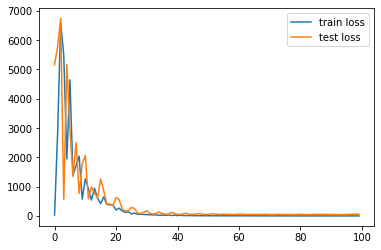

In [12]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

# CNN model

We start by reshaping the data, where images shapes go from $(128, 128, 3)$ to $(3, 128, 128)$

In [58]:
for i in range(len(train_data)):
    train_data[i] = np.swapaxes(np.swapaxes(train_data[i], 2, 3), 1, 2)
    test_data[i] = np.swapaxes(np.swapaxes(test_data[i], 2, 3), 1, 2)

In [59]:
train_features = torch.Tensor(np.concatenate(train_data, axis=0).astype(np.int32))
train_targets = torch.Tensor(np.concatenate(([0 for i in range(train_set)], [1 for i in range(train_set)]), axis=0).astype(np.int32)).type(torch.IntTensor)

test_features = torch.Tensor(np.concatenate(test_data, axis=0).astype(np.int32))
test_targets = torch.Tensor(np.concatenate(([0 for i in range(test_set)], [1 for i in range(test_set)]), axis=0).astype(np.int32)).type(torch.IntTensor)

In [60]:
train_dataset = data_utils.TensorDataset(train_features, train_targets)
test_dataset = data_utils.TensorDataset(test_features, test_targets)

In [61]:
# number of classes
K = 2

In [62]:
# Define the model
class CNN(nn.Module):
    def __init__(self, K):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)

        # define the linear layers
        self.fc1 = nn.Linear(128 * 15 * 15, 1024)
        self.fc2 = nn.Linear(1024, K)
  
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 15 * 15)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)
        return x


In [63]:
# Instantiate the model
model = CNN(K)

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=28800, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)

In [65]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [66]:
batch_size = 250
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

Training loop function:

In [67]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device).type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading

        model.eval()
        test_loss = []
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device).type(torch.LongTensor)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Test Loss: {test_loss:.4f}, Duration: {dt}')
  
    return train_losses, test_losses

In [68]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=10)

Epoch 1/10, Train Loss: 307.1725,           Test Loss: 119.5231, Duration: 0:00:04.633718
Epoch 2/10, Train Loss: 60.7002,           Test Loss: 1.3973, Duration: 0:00:04.354650
Epoch 3/10, Train Loss: 1.0455,           Test Loss: 0.6693, Duration: 0:00:04.308072
Epoch 4/10, Train Loss: 0.6990,           Test Loss: 1.0336, Duration: 0:00:04.331018
Epoch 5/10, Train Loss: 1.0542,           Test Loss: 0.5077, Duration: 0:00:04.307932
Epoch 6/10, Train Loss: 0.5335,           Test Loss: 0.5187, Duration: 0:00:04.352253
Epoch 7/10, Train Loss: 0.4730,           Test Loss: 0.3924, Duration: 0:00:04.339543
Epoch 8/10, Train Loss: 0.3547,           Test Loss: 0.3664, Duration: 0:00:04.296854
Epoch 9/10, Train Loss: 0.3136,           Test Loss: 0.3302, Duration: 0:00:04.401235
Epoch 10/10, Train Loss: 0.2528,           Test Loss: 0.2533, Duration: 0:00:04.295942


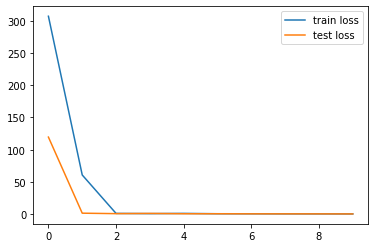

In [69]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()